# Chest X-ray Pipeline Deployment on UCS

This notebook focuses on implementing chest X-ray classification for detecting COVID-19 from a dataset consisting of normal X-rays and COVID X-rays as a Kubeflow pipeline on Cisco UCS.

## Note:

This notebook resources the component files from the Cisco Kubeflow Starter Pack git repository that was already cloned during dataset-builder-minio-store.ipynb notebook implementation. If not cloned earlier, clone from below.

## Clone Cisco Kubeflow starter pack git repository

In [ ]:
! git clone -b master https://github.com/CiscoAI/cisco-kubeflow-starter-pack.git

## Install required packages

In [ ]:
! pip install kfp Pillow --user 

## Restart notebook kernel

In [ ]:
from IPython.display import display_html
display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)

## Import libraries

In [4]:
import os
import calendar
import time
import numpy as np
import requests
import json
import tensorflow
from PIL import Image

#Kubeflow pipeline
import kfp

#Kubernetes
from kubernetes import client

## Load pipeline components

Declare the paths of respective YAML configuration files of each of the pipeline components, in order to load each component into a variable for pipeline execution.

### Components description

tf_download_dataset_op &nbsp;&nbsp; - &nbsp; Download required chest X-ray datasets from minIO storage.<br> 
tf_train_model_op &nbsp;&nbsp;&nbsp; - &nbsp; Load dataset from NFS volume, train chest X-ray model  and save model in NFS volume. <br> 
tf_serve_model_op &nbsp; - &nbsp; Load chest X-ray model from NFS volume and serve the model using tf-serving for later prediction. <br> 

In [5]:
path = 'cisco-kubeflow-starter-pack/apps/healthcare/covid/onprem/pipelines/chest-xray/' 
component_root_download= path + 'components/v2/download_dataset/'
component_root_katib= path + 'components/v2/tf-katib-deploy-service/'
component_root_train= path + 'components/v2/tf-model-train/'
component_root_serve = path + 'components/v2/tf-serving-deploy-service/'

tf_download_dataset_op = kfp.components.load_component_from_file(os.path.join(component_root_download, 'component.yaml'))
tf_katib = kfp.components.load_component_from_file(os.path.join(component_root_katib, 'component.yaml'))
tf_train_model_op = kfp.components.load_component_from_file(os.path.join(component_root_train, 'component.yaml')) 
tf_serve_model_op = kfp.components.load_component_from_file(os.path.join(component_root_serve, 'component.yaml'))

## Define volume claim & volume mount for storage during pipeline execution

Persistent volume claim & volume mount is created for the purpose of storing entities such as Dataset, model files, etc, and to share the stored resources between the various components of the pipeline during it's execution.

In [6]:
nfs_pvc = client.V1PersistentVolumeClaimVolumeSource(claim_name='nfs')
nfs_volume = client.V1Volume(name='nfs', persistent_volume_claim=nfs_pvc)
nfs_volume_mount = client.V1VolumeMount(mount_path='/mnt/', name='nfs')

## Define pipeline function

In [7]:
# Create timestamp
timestamp = str(calendar.timegm(time.gmtime()))

def covid_pipeline():
    
    # Defining Task for downloading dataset
    tf_download_task = tf_download_dataset_op()
    tf_download_task.add_volume(nfs_volume)
    tf_download_task.add_volume_mount(nfs_volume_mount)
    
    # Defining Task for katib hyperparameter values
    tf_katib_task = tf_katib(timestamp=timestamp,image="docker.io/edward1723/katib-trial:0.4") # 'Image : katib-trial:0.4' finds the best parameter 
                                                                                               # values with different trials via Katib
    tf_katib_task.add_volume(nfs_volume)
    tf_katib_task.add_volume_mount(nfs_volume_mount)
    tf_katib_task.after(tf_download_task)
        
    # Defining Task for Model training
    tf_train_model_task = tf_train_model_op(timestamp=timestamp)
    tf_train_model_task.add_volume(nfs_volume)
    tf_train_model_task.add_volume_mount(nfs_volume_mount)
    tf_train_model_task.after(tf_katib_task)
    
    # Defining Task to perform serving    
    tf_serve_model_task = tf_serve_model_op(timestamp=timestamp)
    tf_serve_model_task.add_volume(nfs_volume)
    tf_serve_model_task.add_volume_mount(nfs_volume_mount)
    tf_serve_model_task.after(tf_train_model_task)

## Run pipeline

In [8]:
#Create pipeline run
kfp.Client().create_run_from_pipeline_func(covid_pipeline, arguments={})

RunPipelineResult(run_id=dc4c3e78-1e2c-4ce1-a9fe-4edf8a31b580)

## Run prediction
### Get TF Serving IP and Port

In [9]:
%%bash -s "$timestamp" --out IP_PORT
echo "$(kubectl get svc -n kubeflow -l timestamp=ts-$1 -o=jsonpath='{.items[0].spec.clusterIP}')"
echo "$(kubectl get svc -n kubeflow -l timestamp=ts-$1 -o=jsonpath='{.items[0].spec.ports[1].port}')"

### Data preprocessing & prediction

In [12]:
#Client data preprocess function
def preprocess(image_path):
    sess = tensorflow.keras.backend.get_session()
    img = tensorflow.read_file(image_path)
    img = tensorflow.image.decode_jpeg(img, channels=3)
    img.set_shape([None, None, 3])
    img = tensorflow.image.resize_images(img, (224, 224))
    img = img.eval(session=sess) # convert to numpy array
    img = np.expand_dims(img, 0) # make 'batch' of 1
    return img ,image_path

# Function to predict chest-xray data
def predict(data,test_image_path):
    
    headers = {"content-type": "application/json"}
    data={"signature_name": "serving_default", "instances": data.tolist()}
    url="http://%s:%s/v1/models/Model_Covid:predict"%(IP_PORT.split("\n")[0], IP_PORT.split("\n")[1])
    json_response = requests.post(url, data=json.dumps(data), headers=headers)
    prediction=json_response.json()['predictions']
    labels=[1,0]
    pred = labels[np.argmax(prediction)]
    diction = {'0':'NORMAL','1':'COVID'}
    result = diction[str(pred)]
    print('Xray result : ',result)

    baseheight = 300
    img_output = Image.open(test_image_path)
    hpercent = (baseheight / float(img_output.size[1]))
    wsize = int((float(img_output.size[0]) * float(hpercent)))
    img_res = img_output.resize((wsize, baseheight), Image.ANTIALIAS)
    return img_res

Xray result :  COVID


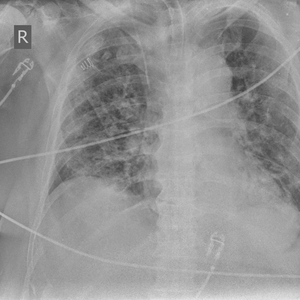

In [19]:
#Call client data preprocess function
test_image = "test_data/00870a9c.jpg"
img_data,image_path=preprocess(os.path.join(path,test_image))

#Call predict function
predict(img_data,image_path)